 ## Modelling & Simulation

---

## Visual System Mapping: Stock & Flow Diagram

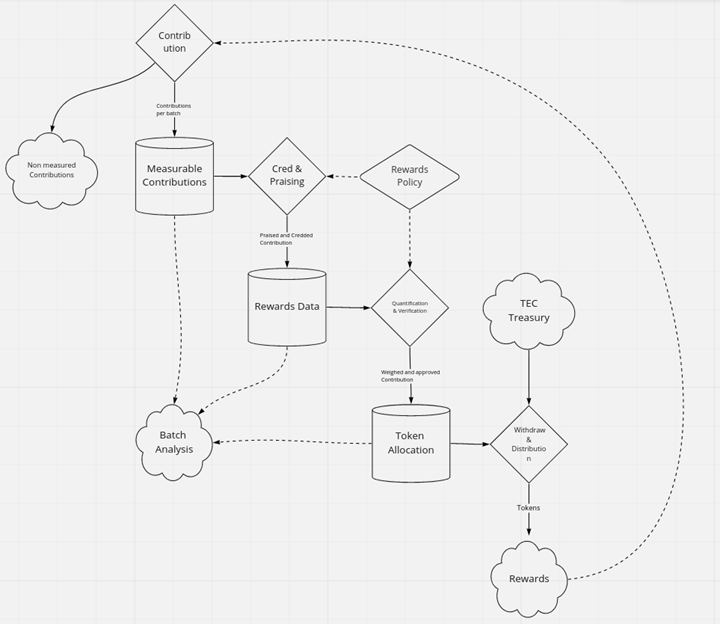

### Differential Equations
* Contributors are rewarded at a rate proportional to the Token allocation.
* Token allocation is based on contributions, and and it is a rate proportional to the TEC Treasury.

\begin{align}
\large contributors_t &\large= contributors_{t-1} + {\Delta contributors} \quad \textrm{(contributors)} \tag{1} \\
\large Tokenallocation_t &\large= Tokenallocation_{t-1} + {\Delta Tokenallocation} \quad \textrm{(Tokens)} \tag{2} \\
\end{align}

where the rate of change ($\Delta$) is:
\begin{align}
\large {\Delta contributors} &\large= \alpha * Tokenallocation_{t-1} \quad \textrm{(contributors/Quater)}  \\
\large {\Delta Tokenallocation} &\large= -\beta * contributors_{t-1} \quad \textrm{(Tokens/Quater)}
\end{align}

# System Design

# 0. Dependencies

In [2]:
!pip install cadCAD

  Running setup.py bdist_wheel for fn: started
  Running setup.py bdist_wheel for fn: finished with status 'done'
  Stored in directory: C:\Users\DELL\AppData\Local\pip\Cache\wheels\1c\0b\45\e33ffd683def8cf196a3a2da660eb5ea630ef47898ae25aae2
Successfully built fn


distributed 1.21.8 requires msgpack, which is not installed.
cryptography 3.3.1 has requirement cffi>=1.12, but you'll have cffi 1.11.5 which is incompatible.
You are using pip version 10.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
# Standard libraries: https://docs.python.org/3/library/
import math

# Analysis and plotting modules
import pandas as pd
# import plotly

In [2]:
# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

# 1. State Variables

> A state variable is one of the set of variables that are used to describe the mathematical "state" of a dynamical system. ([Wikipedia](https://en.wikipedia.org/wiki/State_variable))

In [9]:
initial_state = {
    'contributors': 50, # number of persons
    'TokenAllocation': 1000 # Tokens
}
initial_state

{'population': 50, 'food': 1000}

## **Time** as a system state

<center>
<img src="./images/discrete-time.svg"
     alt="Discrete time"
     style="width: 200px;" />
</center>

* 1 **timestep** == 3 months

# 2. System Parameters

> System parameterization is the process of choosing variables that impact the behaviour of the model. These parameters allow us to perform simulation techniques like parameter sweeps, Monte Carlo simulations, A/B tests, and see how the system behaves under a different model parameter set.

[Link to Simulation Analysis](#9.-Simulation-Analysis)

In [ ]:
system_params = {
    'contribution_rate': [0.01], # person per Quater
    'reward_rate': [0.1], # Tokens per Quater
}
system_params

# 3. Policy Functions

> A Policy Function computes one or more signals to be passed to State Update Functions. They describe the logic  and behaviour of a system component  or mechanism.


# 4. State Update Functions

> We create State Update Functions to design the way our model state changes over time. These will usually represent the system differential specification.

```python
def state_update_function(params, substep, state_history, previous_state, policy_input):
    variable_value = 0
    return 'variable_name', variable_value
```

* `params` is a Python dictionary containing the **system parameters** <!-- for consistency with the previous definition -->
* `substep` is an integer value representing a step within a single `timestep`
* `state_history` is a Python list of all previous states
* `previous_state` is a Python dictionary that defines what the state of the system was at the **previous timestep** or **substep**
* `policy_input` is a Python dictionary of signals or actions from **policy functions**

In [ ]:
def new_contributors(current_contributors, alpha, TokenAllocation_supply):
    """
    The contributors state after one timestep, according to the differential equation (1):
    current_contributors + alpha * TokenAllocation_supply
    """
    return math.ceil(current_contributors + alpha * TokenAllocation_supply)

In [ ]:
math.ceil(5.5)

In [4]:
# Relevant state variables
current_contributors = initial_state['contributors']
TokenAllocation_supply = initial_state['TokenAllocation']

# Relevant parameters
contribution_rate = system_params['contributions_rate'][0] # "alpha" in our differential equation

new_contributors(current_contributors, contribution_rate, TokenAllocation_supply)

NameError: name 'initial_state' is not defined

In [ ]:
def s_contributors(params, substep, state_history, previous_state, policy_input):
    """
    Update the contributors state according to the differential equation (1):
    current_contributors + alpha * Tokenallocation_supply
    """
    contributors = previous_state['contributors']
    alpha = params['contribution_rate']
    TokenAllocation_supply = previous_state['TokenAllocation']
    
    return 'contributors', max(new_contributors(contributors, alpha, TokenAllocation_supply), 0)

In [ ]:
contributors = 60
print("A tuple!")
'contributors', max(math.ceil(contributors), 0)

In [11]:
next_state = {
    # current_contributors + alpha * TokenAllocation_supply
    'contributors': math.ceil(50 + 0.01 * 1000),
    'TokenAllocation': 1000
}
next_state

{'contributors': 60, 'food': 1000}

In [12]:
def s_TokenAllocation(params, substep, state_history, previous_state, policy_input):
    """
    Update the TokenAllocation supply state according to the differential equation (2):
    TokenAllocation supply - beta * population
    """
    TokenAllocation = previous_state['TokenAllocation'] - params['reward_rate'] * previous_state['contributors']
    return 'TokenAllocation', max(TokenAllocation, 0)

In [13]:
max(-10, 0)

0

<center>
<img src="./images/basic-psub.png"
     alt="Policy functions"
     style="width: 60%;" />
</center>

**Updates run in series**

In [3]:
partial_state_update_blocks = [
    # Run first
    {
        'policies': {}, # Ignore for now
        # State variables
        'variables': {
            'contributors': s_contributors
        }
    },
    # Run second
    {
        'policies': {}, # Ignore for now
        # State variables
        'variables': {
            'TokenAllocation': s_TokenAllocation
        }
    }
]

NameError: name 's_contributors' is not defined

**Updates run in parallel**

In [ ]:
partial_state_update_blocks = [
    {
        'policies': {}, # Ignore for now
        # State variables
        'variables': {
            # Updated in parallel
            'contributors': s_contributors,
            'TokenAllocation': s_TokenAllocation
        }
    }
]

# 6. Configuration

> The configuration stage is about tying all the previous model components together and choosing how the simulation should run.

<center>
<img src="./images/cadcad-flow.png"
     alt="cadCAD flow"
     style="width: 25%;" />
</center>

Configuration parameters:
* `'N': 1` - the number of times we'll run the simulation (you'll see them called "Monte Carlo runs" later in the course, when we look at tools to analyze system models)
* `'T': range(400)` - the number of timesteps the simulation will run for
* `'M': system_params` - the parameters of the system

In [ ]:
sim_config = config_sim({
    "N": 1,
    "T": range(400),
    "M": system_params
})

In [ ]:
range(400)

In [ ]:
list(range(400))[0:10]

In [ ]:
from cadCAD import configs
del configs[:] # Clear any prior configs

In [ ]:
experiment = Experiment()
experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)
configs[-1].__dict__

# 7. Execution

> The Execution Engine takes a model and configuration, and computes the simulation output.

## Configuring the cadCAD simulation execution

In [ ]:
exec_context = ExecutionContext()

In [ ]:
simulation = Executor(exec_context=exec_context, configs=configs)

## Time to simulate our ecosystem model!

In [ ]:
raw_result, tensor_field, sessions = simulation.execute()

# 8. Simulation Output Preparation
> The simulation results are returned as a list of Python dictionaries, which we then convert to a Pandas dataframe. At this stage of the process you'll manipulate and analyze your results to answer questions about your model.

In [ ]:
simulation_result = pd.DataFrame(raw_result)

In [ ]:
raw_result[:5]

In [ ]:
simulation_result.head()

# 9. Simulation Analysis

[Link to System Requirements](#Requirements-Analysis)

In [ ]:
pd.options.plotting.backend = "plotly"

After plotting the results, let's go and update the parameters, and then select `Cell` and `Run All Above`:

[Link to System Parameters](#2.-System-Parameters)

In [ ]:
simulation_result.plot(
    kind='line',
    x='timestep',
    y=['contributors','TokenAllocation']
)

In [ ]:
pd.set_option('display.max_rows', len(simulation_result))
display(simulation_result)
pd.reset_option('display.max_rows')

In [ ]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html
simulation_result.query('TokenAllocation == 0').head()

# System Validation

<center><img src="images/edp-phase-3.png" alt="Engineering Design Process, phase 1 - validation" width="60%"/>

## Policy Functions

An illustrative example:

```python
condition = True

def policy_function(params, substep, state_history, previous_state):
    '''
    This logic belongs in the policy function,
    but could also have been placed directly in the state update function.
    '''
    signal_value = 1 if condition else 0
    return {'signal_name': signal_value}
```

```python
def state_update_function(params, substep, state_history, previous_state, policy_input):
    state_value = policy_input['signal_name']
    return 'state_name', state_value
```

<center>
<img src="./images/basic-psub.png"
     alt="Policy functions"
     style="width: 60%;" />
</center>

<center>
<img src="./images/policy-explainer.png"
     alt="Policy functions"
     style="width: 60%;" />
</center>

### Policy Aggregation

<center>
<img src="./images/policy-aggregation-explainer.png"
     alt="Policy functions"
     style="width: 60%;" />
</center>

## Model Improvements

### Differential Specification Updates

<center>
<img src="./images/s5-differential-spec-ecosystem-policy-refactor.png"
     alt="Differential spec"
     style="width: 60%;" />
</center>

State update functions `s_contributors()` and `s_TokenAllocation()` from the last part:

In [ ]:
def s_contributors(params, substep, state_history, previous_state, policy_input):
    contributors = previous_state['contributors'] + params['contribution_rate'] * previous_state['TokenAllocation']
    return 'contributors', max(math.ceil(population), 0)

def s_TokenAllocation(params, substep, state_history, previous_state, policy_input):
    TokenAllocation = previous_state['TokenAllocation'] - params['reward_rate'] * previous_state['contributors']
    return 'TokenAllocation', max(TokenAllocation, 0)

Adapting to use **policy functions** to drive the process, and **state update functions** to update the state according to the **differential specification**:

In [ ]:
def p_onboarding(params, substep, state_history, previous_state):
    contributors_onboarding = params['contribution_rate'] * previous_state['TokenAllocation']
    return {'delta_contributors': contributors_onboarding}

def p_TokenTreasury(params, substep, state_history, previous_state):
    TokenAllocation_Treasury = params['reward_rate'] * previous_state['contributors']
    return {'delta_TokenAllocation': -TokenAllocation_TokenTreasury}

In [ ]:
def s_contributors(params, substep, state_history, previous_state, policy_input):
    contributors = previous_state['contributors'] + policy_input['delta_contributors'] 
    return 'contributors', max(math.ceil(contributors), 0)

def s_TokenAllocation(params, substep, state_history, previous_state, policy_input):
    ToekenAllocation = previous_state['TokenAllocation'] + policy_input['delta_TokenAllocation'] 
    return 'TokenAllocation', max(TokenAllocation, 0)

### Mathematical Specification Updates

\begin{align}
\large population_t &\large= population_{t-1} + {\Delta population} \quad \textrm{(sheep)} \tag{1} \\
\large food_t &\large= food_{t-1} + {\Delta food} \quad \textrm{(tons of grass)} \tag{2}
\end{align}

where the rate of change ($\Delta$) is:
\begin{align}
\large {\Delta population} &\large= \alpha * food_{t-1} \quad \textrm{(sheep/month)} \\
\large {\Delta food} &\large= -\beta * population_{t-1} + \gamma \quad \textrm{(tons of grass/month)}
\end{align}

where:

$
\begin{align}
\alpha: \quad &\textrm{'reproduction_rate'}\\
\beta: \quad &\textrm{'consumption_rate'}\\
\gamma: \quad &\textrm{'growth_rate'}
\end{align}
$

* A population consumes a food source, and reproduces at a rate proportional to the food source $\alpha$ (alpha).
* The food source is consumed at a rate proportional to the population $\beta$ (beta), and grows at a constant rate $\gamma$ (gamma).

<center>
<img src="./images/s6-differential-spec-ecosystem-with-gamma.png"
     alt="Diff spec"
     style="width: 60%" />
</center>

In [ ]:
initial_state = {
    'Contributors': 50, # number of sheep
    'TokenAllocation': 1000 # tons of grass
}

system_params = {
    'reproduction_rate': [0.01], # number of sheep / month
    'consumption_rate': [0.01], # tons of grass / month
    'growth_rate': [10.0], # persons / Quater
}

In [ ]:
from collections import Counter

In [ ]:
A = Counter({'delta_TokenAllocation': 5, 'delta_contributors': 10})
B = Counter({'delta_TokenAllocation': 5})
A + B

In [ ]:
A = Counter({'delta_TokenAllocation': 5, 'delta_contributors': 10})
B = Counter({'delta_contributors': -2})
A + B

In [ ]:
def p_growth(params, substep, state_history, previous_state):
    delta_TokenAllocation = params['growth_rate']
    return {'delta_TokenAllocation': delta_TokenAllocation}

In [ ]:
partial_state_update_blocks = [
    {
        'policies': {
            'contributors_onboarding': p_contributors_onboarding,
            'TokenTreasury': p_TokenTreasury, # Signal: `delta_TokenAllocation`
            'growth': p_growth # Signal: `delta_TokenAllocation`
        },
        'variables': {
            'contributors': s_contributors,
            'TokenAllocation': s_tokenAllocation # Receives policy_input of (TokenTreasury + growth) as `delta_TokenAllocation`
        }
    }
]

In [ ]:
del configs[:]

sim_config = config_sim({
    'N': 1,
    'T': range(400),
    'M': system_params
})

experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

In [ ]:
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs)
raw_result, tensor_field, sessions = simulation.execute()

In [ ]:
simulation_result = pd.DataFrame(raw_result)
simulation_result

In [ ]:
df = simulation_result.copy()
df = df[df.simulation == 0]
df

In [ ]:
df.plot(kind='line', x='timestep', y=['contributors','TokenAllocation'])

In [ ]:
df = df[['contributors', 'TokenAllocation']]
df.head()

In [ ]:
df.pct_change()

In [ ]:
diff = df.diff()
diff

In [ ]:
diff = diff.query('TokenAllocation <= 0')
diff

In [ ]:
df.iloc[75]

## Model Limitations

1. The contributor never siezes.
2. The system reaches a steady state of no contributors or TokenAllocation input change.

#### Addition of a contributors death rate, "epsilon" / $\epsilon$, that's dependent on the contributors size:
<br>

\begin{align}
\large contributors_t &\large= contributors_{t-1} + {\Delta contributors} \quad \textrm{(persons)} \tag{1} \\
\large TokenAllocation_t &\large= TokenAllocation_{t-1} + {\Delta TokenAllocation} \quad \textrm{(Tokens)} \tag{2}
\end{align}

where the rate of change ($\Delta$) is:
\begin{align}
\large {\Delta contributors} &\large= \alpha * contributors_{t-1} - \epsilon * contributors_{t-1} \quad \textrm{(persons/Quater)} \\
\large {\Delta TokenAllocation} &\large= -\beta * contributors_{t-1} + \gamma \quad \textrm{(Tokens /Quater)}
\end{align}

where:

$
\begin{align}
\alpha: \quad &\textrm{'contribuors_onboarding_rate'}\\
\epsilon: \quad &\textrm{'exhaustion_rate'}\\
\beta: \quad &\textrm{'TokenTreasury_rate'}\\
\gamma: \quad &\textrm{'growth_rate'}\\
\end{align}
$

* The contributors receive a TokenAllocation source, and receive rewards at a rate proportional to the TokenAllocation source $\alpha$ (alpha), and depleted at a rate proportional to the contributors_rewards size $\epsilon$ (epsilon).
* The TokenAllocation source is consumed at a rate proportional to the contributors_rewards $\beta$ (beta), and grows at a constant rate $\gamma$ (gamma).

<center>
<img src="./images/s6-differential-spec-ecosystem-final.png"
     alt="Diff spec"
     style="width: 60%" />
</center>

In [ ]:
def p_depletion(params, substep, state_history, previous_state):
    contributors_depletion = params['depletion_rate'] * previous_state['contributors']
    return {'delta_contributors': -contributors_depletion}

In [ ]:
initial_state = {
    'contributors': 50, # number of persons
    'TokenAllocation': 1000 # Tokens
}

system_params = {
    'contributors_onboarding_rate': [0.01],
    'depletion_rate': [0.01],
    'TokenTreasury_rate': [0.01],
    'growth_rate': [10.0],
}

In [ ]:
partial_state_update_blocks = [
    {
        'policies': {
            'contributors_onboarding': p_contributors_onboarding,
            'depletion': p_depletion,
            'tokenTreasury': p_tokenTreasury,
            'growth': p_growth
        },
        'variables': {
            'contributors': s_contributors,
            'TokenAllocation': s_TokenAllocation
        }
    }
]

In [ ]:
sim_config = config_sim({
    'N': 1,
    'T': range(1000),
    'M': system_params
})

experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

In [ ]:
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs)
raw_result, tensor_field, sessions = simulation.execute()

In [ ]:
simulation_result = pd.DataFrame(raw_result)

In [ ]:
df = simulation_result.copy()
df = df[df.simulation == 1]
df

In [ ]:
df.plot(kind='line', x='timestep', y=['contributors','tokenAllocation'])